In [1]:
import os
import pandas as pd
import geopandas as gpd
import plotly.express as px
import ast
%pylab inline

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 40000)
pd.set_option('display.max_rows', None)

df_safegraph_poi = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_POI_Yellowstone_200miRadius.csv.gz'))
df_safegraph_spend = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_SPEND_Yellowstone_200miRadius.csv.gz'))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
mask = df_safegraph_poi['CITY'] == 'Yellowstone National Park'
df_park_poi = df_safegraph_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_park = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_park_poi['PLACEKEY'])]
else:
    print("Error: DataFrame does not contain 'PLACEKEY' column.")

print(df_park.head(10))

                  PLACEKEY                        SAFEGRAPH_BRAND_IDS                               BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                    BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_O

## Functions

In [3]:
def time_filt(df, start, end):
    datetime_start = pd.to_datetime(start)
    datetime_end = pd.to_datetime(end)
    df_copy = df.copy()
    
    df_copy['SPEND_DATE_RANGE_START'] = pd.to_datetime(df_copy['SPEND_DATE_RANGE_START'])
    df_copy['SPEND_DATE_RANGE_END'] = pd.to_datetime(df_copy['SPEND_DATE_RANGE_END'])
    
    df_filtered = df_copy[(df_copy['SPEND_DATE_RANGE_START'] >= datetime_start) &
                                 (df_copy['SPEND_DATE_RANGE_END'] <= datetime_end)]
    
    return df_filtered


In [4]:
def percent_instate(df):
    home_city = df['CUSTOMER_HOME_CITY']
    in_state = 0
    out_state = 0

    for val in df['CUSTOMER_HOME_CITY']:
        cities = val.split(",")
        cities = cities[1::2]
        for i in cities:
            state = i.split(':')
            if(state[0].find("WY") != 1):
                count = state[1].strip("{}")
                out_state += int(count)
            else:
                count = state[1].strip("{}")
                in_state += int(count)
    
    print('Out of state: ', out_state)
    print('In state: ', in_state)
    print('Percentage out of state:', (out_state)/(in_state+out_state)*100, '%')
    
    return [in_state, out_state]

In [5]:
def percent_change_month(df):
    pct_change_month = df['SPEND_PCT_CHANGE_VS_PREV_MONTH'].dropna()
    
    sum = 0
    product = 1
    for val in pct_change_month:
        sum += val/100
        product *= val/100
    pct_change_total = (sum + product)*100
    return pct_change_total

In [6]:
def percent_change_year(df):
    pct_change_year = df['SPEND_PCT_CHANGE_VS_PREV_YEAR'].dropna()
    
    sum = 0
    product = 1
    for val in pct_change_year:
        sum += val/100
        product *= val/100
    pct_change_total = (sum + product)*100
    return pct_change_total

In [7]:
def spend_by_day(df):
    df_filtered = df.copy()

    # Convert string representations of lists in 'SPEND_BY_DAY' to actual lists
    df_filtered['SPEND_BY_DAY'] = df_filtered['SPEND_BY_DAY'].apply(ast.literal_eval)

    # Add a new column called 'DATE_OF_MONTH', as a list of integers from 1 to the end of the month (length of the 'SPEND_BY_DAY' list)
    df_filtered['DATE_OF_MONTH'] = df_filtered['SPEND_BY_DAY'].apply(lambda x: list(range(1, len(x) + 1)))

    df_spend_by_day = df_filtered.explode(['SPEND_BY_DAY', 'DATE_OF_MONTH'])

    df_spend_by_day['SPEND_BY_DAY'] = df_spend_by_day['SPEND_BY_DAY'].astype(float)
    df_spend_by_day['DATE_OF_MONTH'] = df_spend_by_day['DATE_OF_MONTH'].astype(int)

    df_spend_by_day['DATE'] = pd.to_datetime(df_spend_by_day['SPEND_DATE_RANGE_START']) + pd.to_timedelta(df_spend_by_day['DATE_OF_MONTH'] - 1, unit='D')

    df_grouped = df_spend_by_day.groupby('DATE')['SPEND_BY_DAY'].sum()

    return df_grouped

## General Yellowstone National Park

In [8]:
df_park_flood = time_filt(df_park, '2022-05-01', '2022-08-01')
df_flood_spending = spend_by_day(df_park_flood)

before_flood = df_flood_spending[33:40]
during_flood = df_flood_spending[40:47]
after_flood = df_flood_spending[47:54]
print(before_flood)
print(during_flood)
print(after_flood)

DATE
2022-06-03    3248.96
2022-06-04    1395.60
2022-06-05    2202.38
2022-06-06    4501.21
2022-06-07    3929.97
2022-06-08    1150.71
2022-06-09    4187.46
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10    1467.90
2022-06-11    1785.32
2022-06-12    1619.30
2022-06-13    4057.10
2022-06-14    2610.66
2022-06-15      53.46
2022-06-16       0.00
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17       5.71
2022-06-18       0.00
2022-06-19       0.00
2022-06-20       0.00
2022-06-21     798.74
2022-06-22    1642.95
2022-06-23    1529.12
Name: SPEND_BY_DAY, dtype: float64


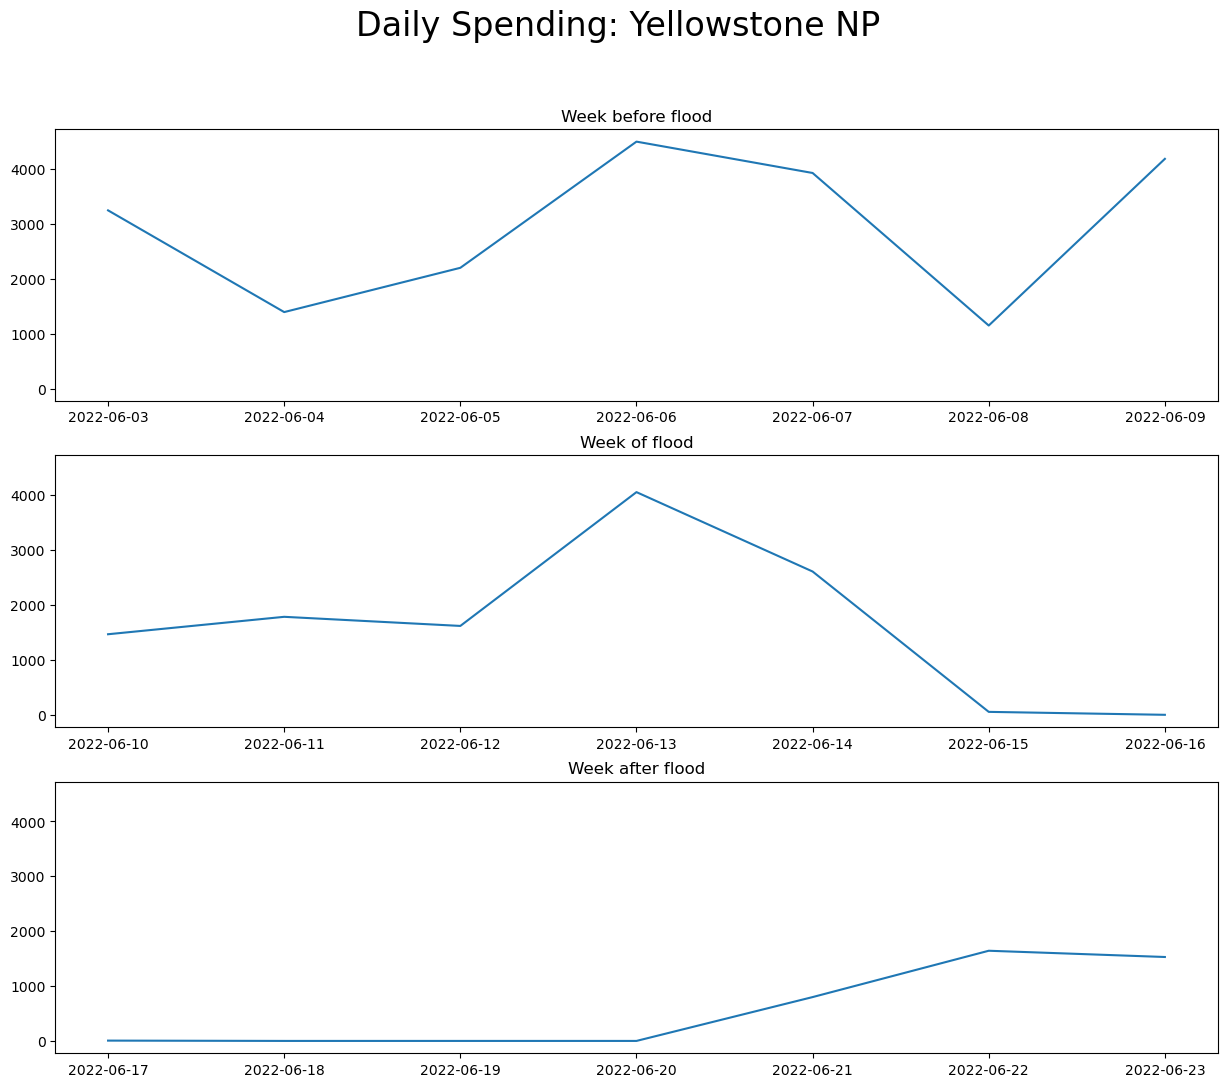

In [35]:
fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood)
ax1.set_title('Week before flood');
ax2.plot(during_flood)
ax2.set_title('Week of flood');
ax3.plot(after_flood)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending: Yellowstone NP', fontsize='24');

In [10]:
before_flood_start = '2022-05-01'
before_flood_end = '2022-06-01'

df_park_before = time_filt(df_park, before_flood_start, before_flood_end)


In [11]:
during_flood_start = '2022-06-01'
during_flood_end = '2022-07-01'

df_park_during = time_filt(df_park, during_flood_start, during_flood_end)

In [12]:
after_flood_start = '2022-07-01'
after_flood_end = '2022-08-01'

df_park_after = time_filt(df_park, after_flood_start, after_flood_end)
print(df_park_after)

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND  TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                        BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_CROSS_SHOPPING_SAME_CA

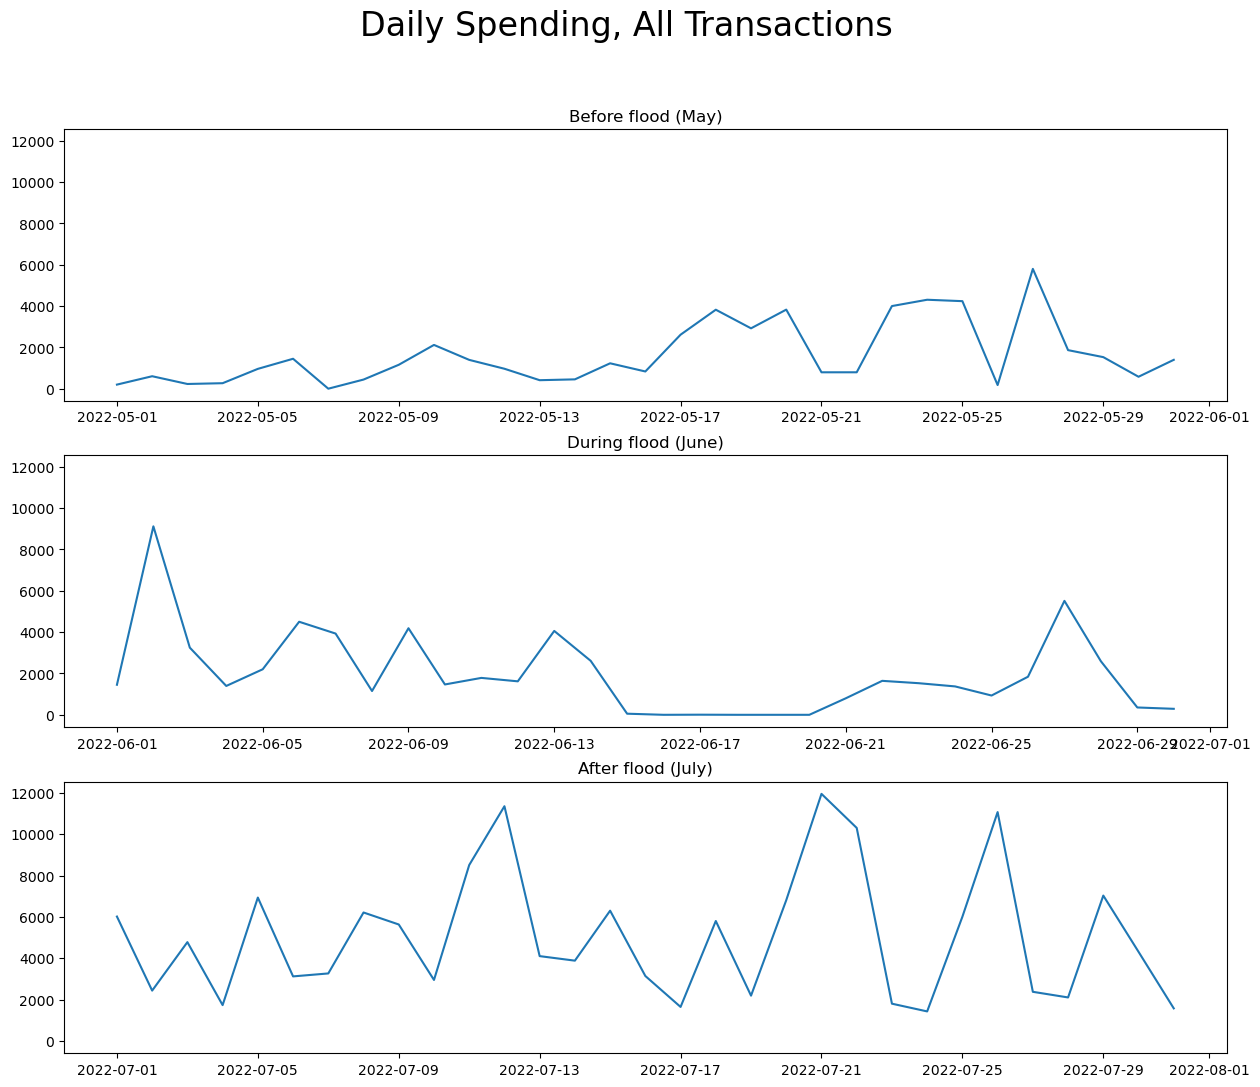

In [13]:
df_spend_before = spend_by_day(df_park_before)
df_spend_during = spend_by_day(df_park_during)
df_spend_after = spend_by_day(df_park_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(df_spend_before)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, All Transactions', fontsize='24');

In [14]:
print('Percent Change April to May: ')
print(percent_change_month(df_park_before), '%\n')

print('Percent Change May to Jume: ')
print(percent_change_month(df_park_during), '%\n')

print('Percent Change June to July: ')
print(percent_change_month(df_park_after), '%\n')

Percent Change April to May: 
2646.952799999999 %

Percent Change May to Jume: 
222.98250757120002 %

Percent Change June to July: 
319.216544 %



In [15]:
print('Percent Change May 2021 to May 2022: ')
print(percent_change_year(df_park_before), '%\n')

print('Percent Change June 2021 to Jume 2022: ')
print(percent_change_year(df_park_during), '%\n')

print('Percent Change July 2021 to July 2022: ')
print(percent_change_year(df_park_after), '%\n')

Percent Change May 2021 to May 2022: 
424.076352464 %

Percent Change June 2021 to Jume 2022: 
-137.0076599936 %

Percent Change July 2021 to July 2022: 
79.00629856 %



Before Flooding: 
Out of state:  911
In state:  6
Percentage out of state: 99.34569247546347 %


During Flooding: 
Out of state:  1119
In state:  10
Percentage out of state: 99.11426040744021 %


After Flooding: 
Out of state:  1710
In state:  32
Percentage out of state: 98.1630309988519 %




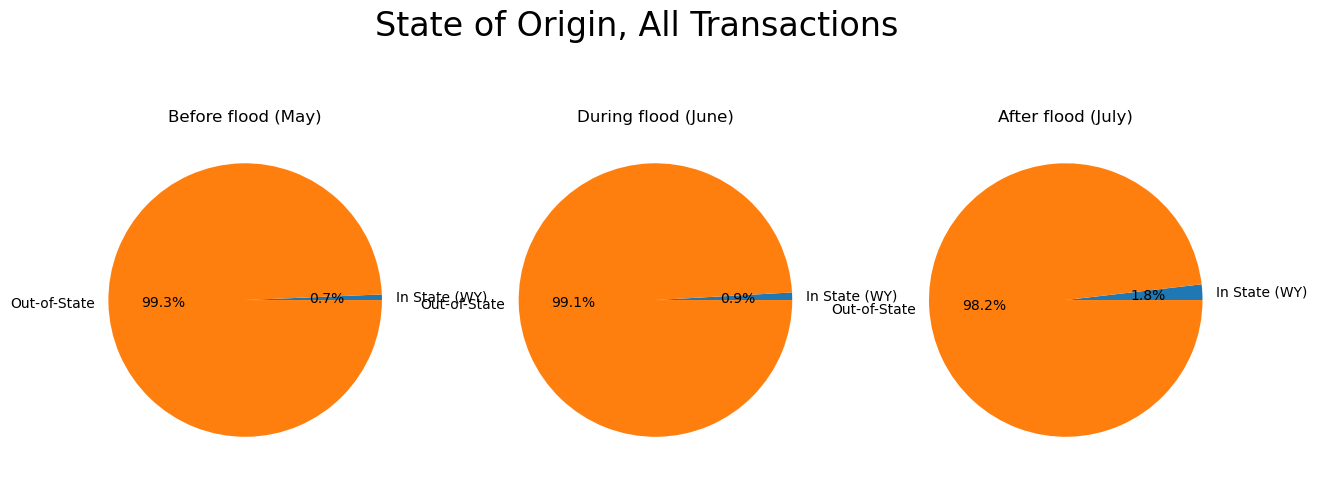

In [16]:
print('Before Flooding: ')
before = percent_instate(df_park_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_park_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_park_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));
ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');

fig.suptitle('State of Origin, All Transactions', fontsize='24');

In [17]:
month = ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', 
         '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01']

df_park_jan = time_filt(df_park, month[0], month[1])
df_park_feb = time_filt(df_park, month[1], month[2])
df_park_mar = time_filt(df_park, month[2], month[3])
df_park_apr = time_filt(df_park, month[3], month[4])
df_park_may = time_filt(df_park, month[4], month[5])
df_park_jun = time_filt(df_park, month[5], month[6])
df_park_jul = time_filt(df_park, month[6], month[7])
df_park_aug = time_filt(df_park, month[7], month[8])
df_park_sep = time_filt(df_park, month[8], month[9])
df_park_oct = time_filt(df_park, month[9], month[10])
df_park_nov = time_filt(df_park, month[10], month[11])
df_park_dec = time_filt(df_park, month[11], month[12])

month_dfs = [df_park_jan, df_park_feb, df_park_mar, df_park_apr, df_park_may, df_park_jun, 
             df_park_jul, df_park_aug, df_park_sep, df_park_oct, df_park_nov, df_park_dec]

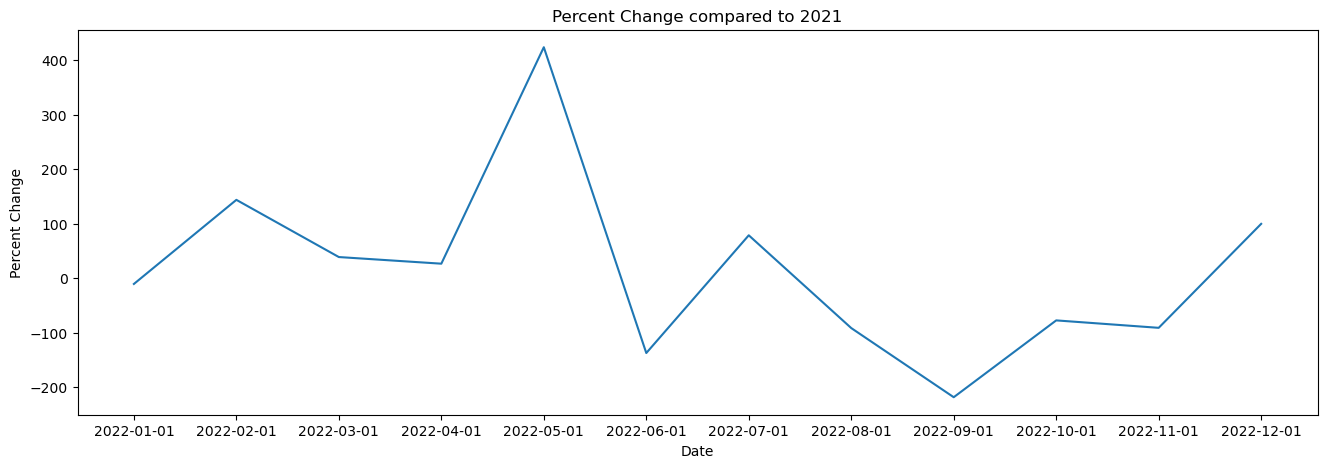

In [18]:
prev_year_pct=[]

for i in range(0, len(month_dfs)):
    prev_year_pct.append(percent_change_year(month_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

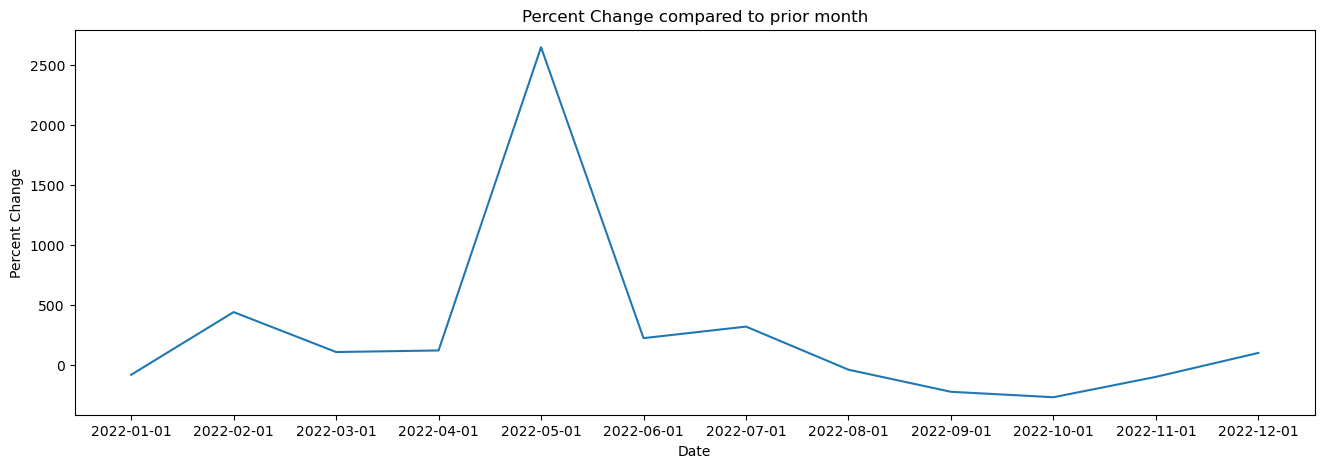

In [19]:
prev_month_pct=[]

for i in range(0, len(month_dfs)):
    prev_month_pct.append(percent_change_month(month_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Yellowstone National Park Accomodations

In [20]:
accomodation_naics = '721'
mask = [ str(ncode)[:3]==accomodation_naics for ncode in list(df_park_poi['NAICS_CODE']) ]
df_hotels_pois = df_park_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_park_hotels = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_hotels_pois['PLACEKEY'])]

df_hotel_before = time_filt(df_park_hotels, before_flood_start, before_flood_end)
print(df_hotel_before.head(5), '\n')

df_hotel_during = time_filt(df_park_hotels, during_flood_start, during_flood_end)
print(df_hotel_during.head(5), '\n')

df_hotel_after = time_filt(df_park_hotels, after_flood_start, after_flood_end)
print(df_hotel_after.head(5), '\n')

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND          TRANSACTION_INTERMEDIARY         SPEND_BY_TRANSACTION_INTERMEDIARY                 BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY            BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_CROSS_SHOPPING_SAME_CATEGOR

DATE
2022-06-03    2390.96
2022-06-04     443.88
2022-06-05    1559.49
2022-06-06    1202.60
2022-06-07    3363.97
2022-06-08       0.00
2022-06-09    1185.57
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     580.81
2022-06-11    1029.15
2022-06-12     622.95
2022-06-13    2323.24
2022-06-14       0.00
2022-06-15       0.00
2022-06-16       0.00
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    0.0
2022-06-18    0.0
2022-06-19    0.0
2022-06-20    0.0
2022-06-21    0.0
2022-06-22    0.0
2022-06-23    0.0
Name: SPEND_BY_DAY, dtype: float64


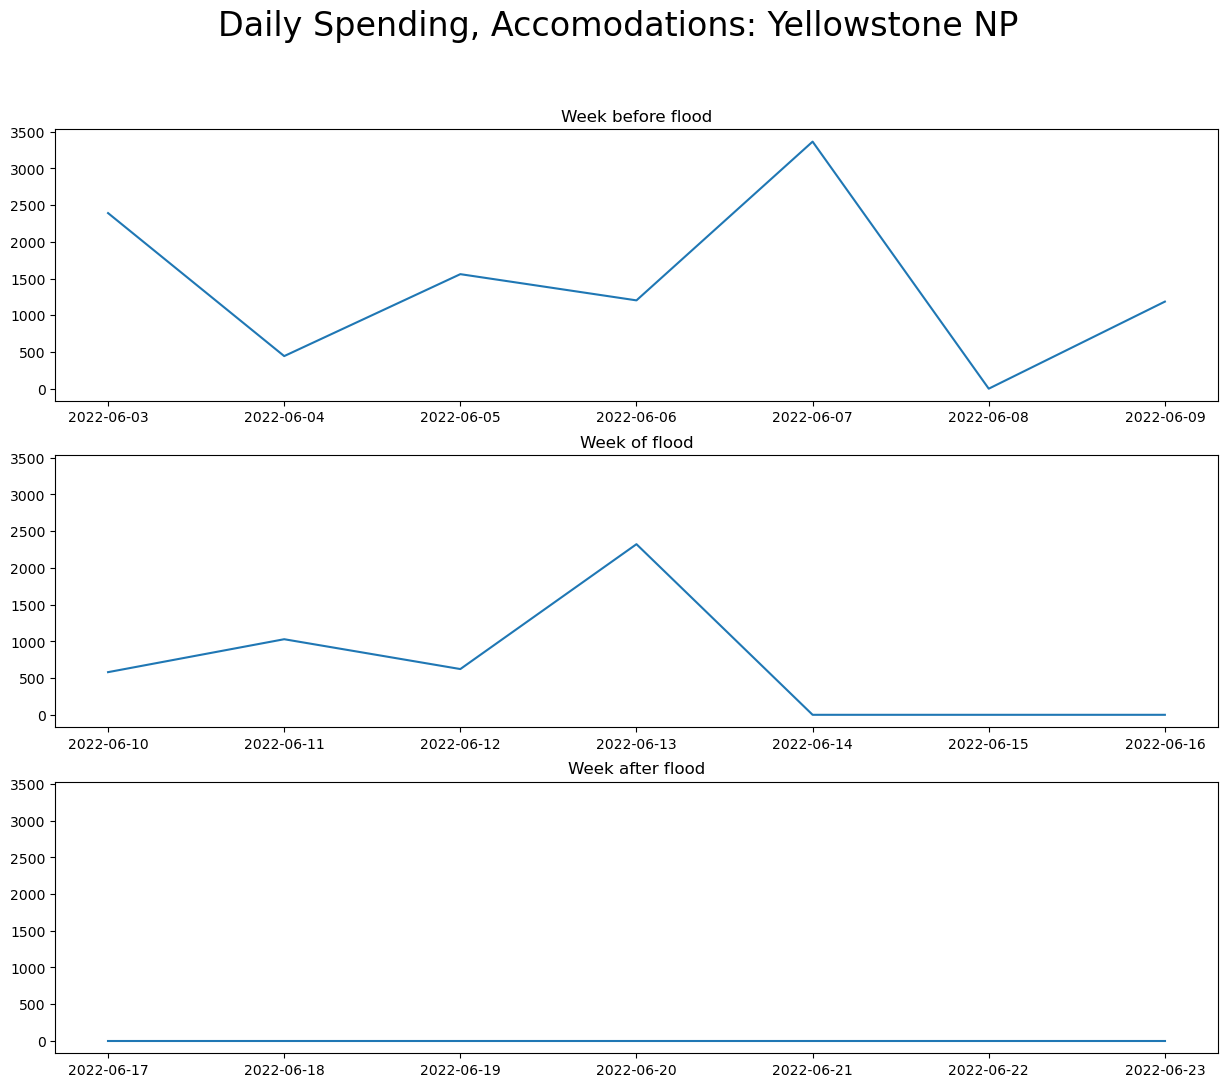

In [34]:
df_hotel_flood = time_filt(df_park_hotels, '2022-05-01', '2022-08-01')
df_flood_spending_hotels = spend_by_day(df_hotel_flood)

before_flood_hotels = df_flood_spending_hotels[33:40]
during_flood_hotels = df_flood_spending_hotels[40:47]
after_flood_hotels = df_flood_spending_hotels[47:54]
print(before_flood_hotels)
print(during_flood_hotels)
print(after_flood_hotels)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_hotels)
ax1.set_title('Week before flood');
ax2.plot(during_flood_hotels)
ax2.set_title('Week of flood');
ax3.plot(after_flood_hotels)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Accomodations: Yellowstone NP', fontsize='24');

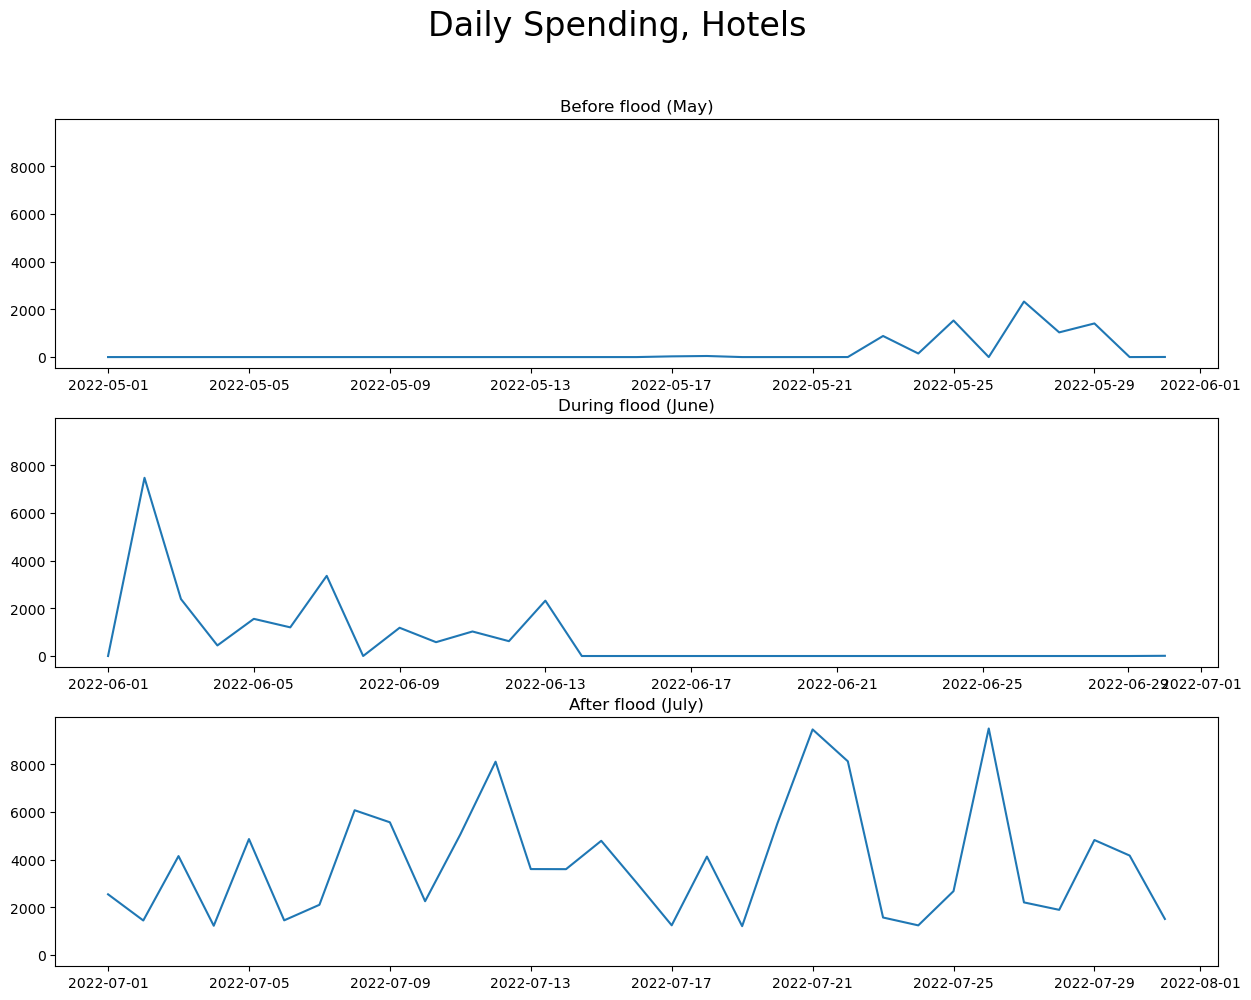

In [22]:
df_spend_before_hotel = spend_by_day(df_hotel_before)
df_spend_during_hotel = spend_by_day(df_hotel_during)
df_spend_after_hotel = spend_by_day(df_hotel_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_hotel)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_hotel)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_hotel)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Hotels', fontsize='24');

Before Flooding: 
Out of state:  31
In state:  0
Percentage out of state: 100.0 %


During Flooding: 
Out of state:  35
In state:  0
Percentage out of state: 100.0 %


After Flooding: 
Out of state:  1029
In state:  18
Percentage out of state: 98.28080229226362 %




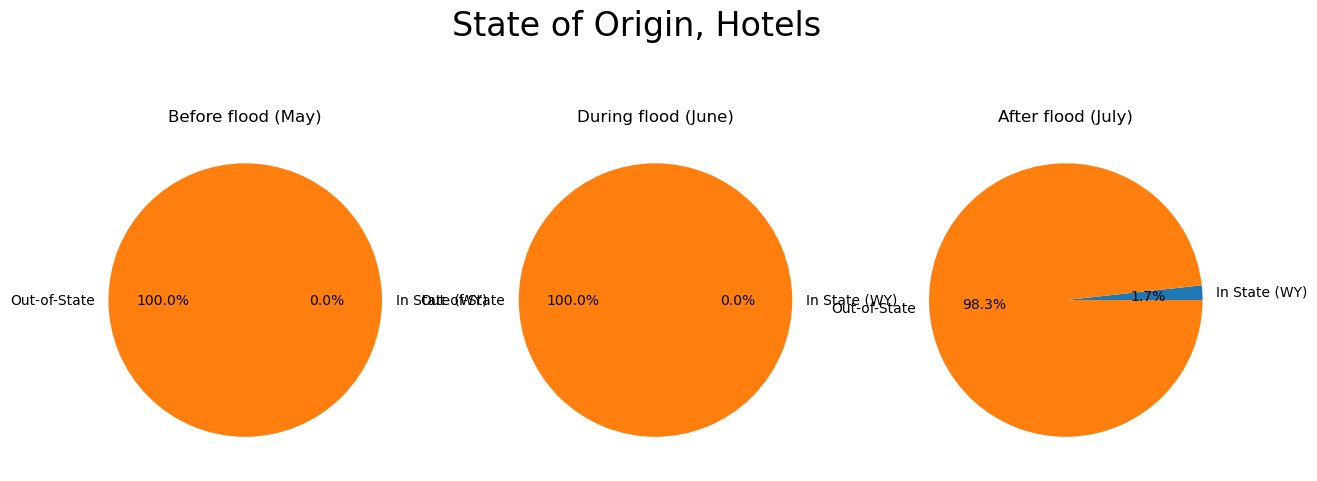

In [23]:
print('Before Flooding: ')
before = percent_instate(df_hotel_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_hotel_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_hotel_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Hotels', fontsize='24');

In [25]:
df_hotel_jan = time_filt(df_park_hotels, month[0], month[1])
df_hotel_feb = time_filt(df_park_hotels, month[1], month[2])
df_hotel_mar = time_filt(df_park_hotels, month[2], month[3])
df_hotel_apr = time_filt(df_park_hotels, month[3], month[4])
df_hotel_may = time_filt(df_park_hotels, month[4], month[5])
df_hotel_jun = time_filt(df_park_hotels, month[5], month[6])
df_hotel_jul = time_filt(df_park_hotels, month[6], month[7])
df_hotel_aug = time_filt(df_park_hotels, month[7], month[8])
df_hotel_sep = time_filt(df_park_hotels, month[8], month[9])
df_hotel_oct = time_filt(df_park_hotels, month[9], month[10])
df_hotel_nov = time_filt(df_park_hotels, month[10], month[11])
df_hotel_dec = time_filt(df_park_hotels, month[11], month[12])

hotel_dfs = [df_hotel_jan, df_hotel_feb, df_hotel_mar, df_hotel_apr, df_hotel_may, df_hotel_jun, 
             df_hotel_jul, df_hotel_aug, df_hotel_sep, df_hotel_oct, df_hotel_nov, df_hotel_dec]

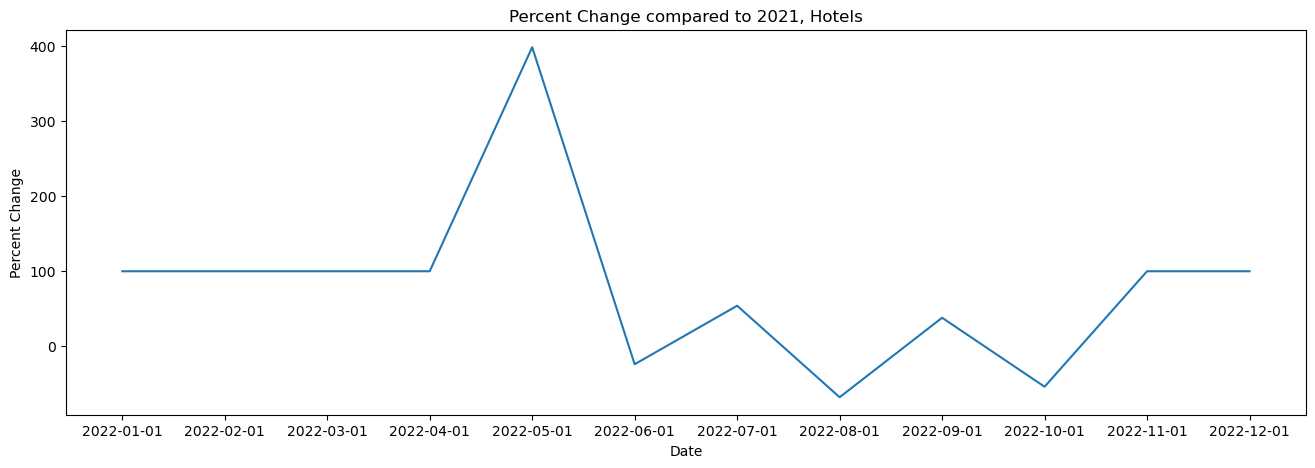

In [26]:
prev_year_pct=[]

for i in range(0, len(hotel_dfs)):
    prev_year_pct.append(percent_change_year(hotel_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Hotels');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

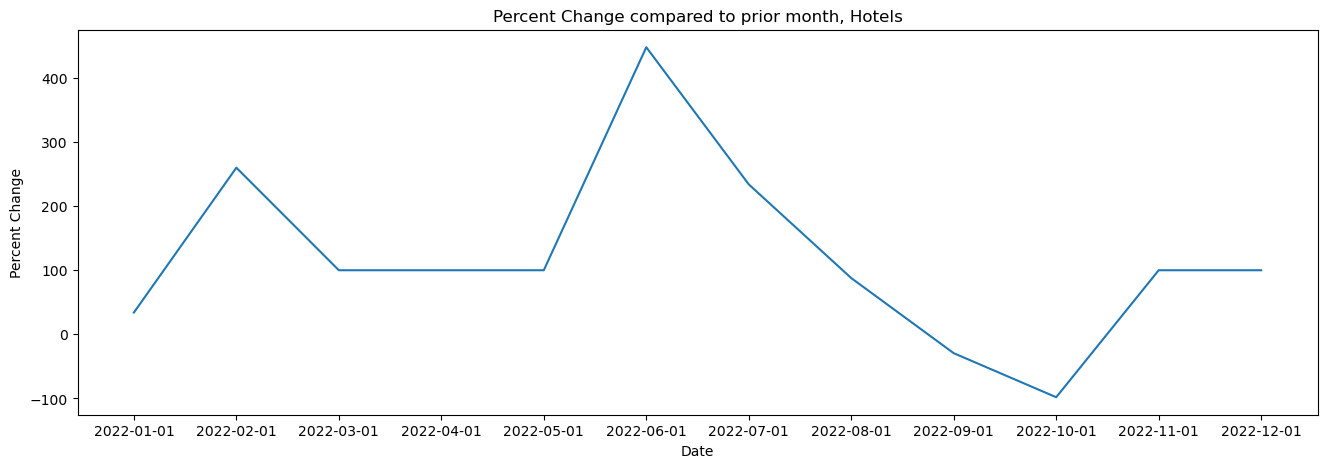

In [27]:
prev_month_pct=[]

for i in range(0, len(hotel_dfs)):
    prev_month_pct.append(percent_change_month(hotel_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Hotels');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Cody Food

In [28]:
food_naics = '722'
mask = [ str(ncode)[:3]==food_naics for ncode in list(df_park_poi['NAICS_CODE']) ]
df_food_pois = df_park_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_park_food = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_food_pois['PLACEKEY'])]

df_food_before = time_filt(df_park_food, before_flood_start, before_flood_end)
print(df_food_before.head(5), '\n')

df_food_during = time_filt(df_park_food, during_flood_start, during_flood_end)
print(df_food_during.head(5), '\n')

df_food_after = time_filt(df_park_food, after_flood_start, after_flood_end)
print(df_food_after.head(5), '\n')

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                    BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_CROSS_SHOPPING_SAME_CATEGOR

DATE
2022-06-03       0.00
2022-06-04     786.72
2022-06-05       0.00
2022-06-06    2005.86
2022-06-07       0.00
2022-06-08     844.71
2022-06-09    2388.40
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     24.94
2022-06-11    346.55
2022-06-12      0.00
2022-06-13    213.86
2022-06-14    434.58
2022-06-15      0.00
2022-06-16      0.00
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17      5.71
2022-06-18      0.00
2022-06-19      0.00
2022-06-20      0.00
2022-06-21    396.74
2022-06-22    709.62
2022-06-23    510.30
Name: SPEND_BY_DAY, dtype: float64


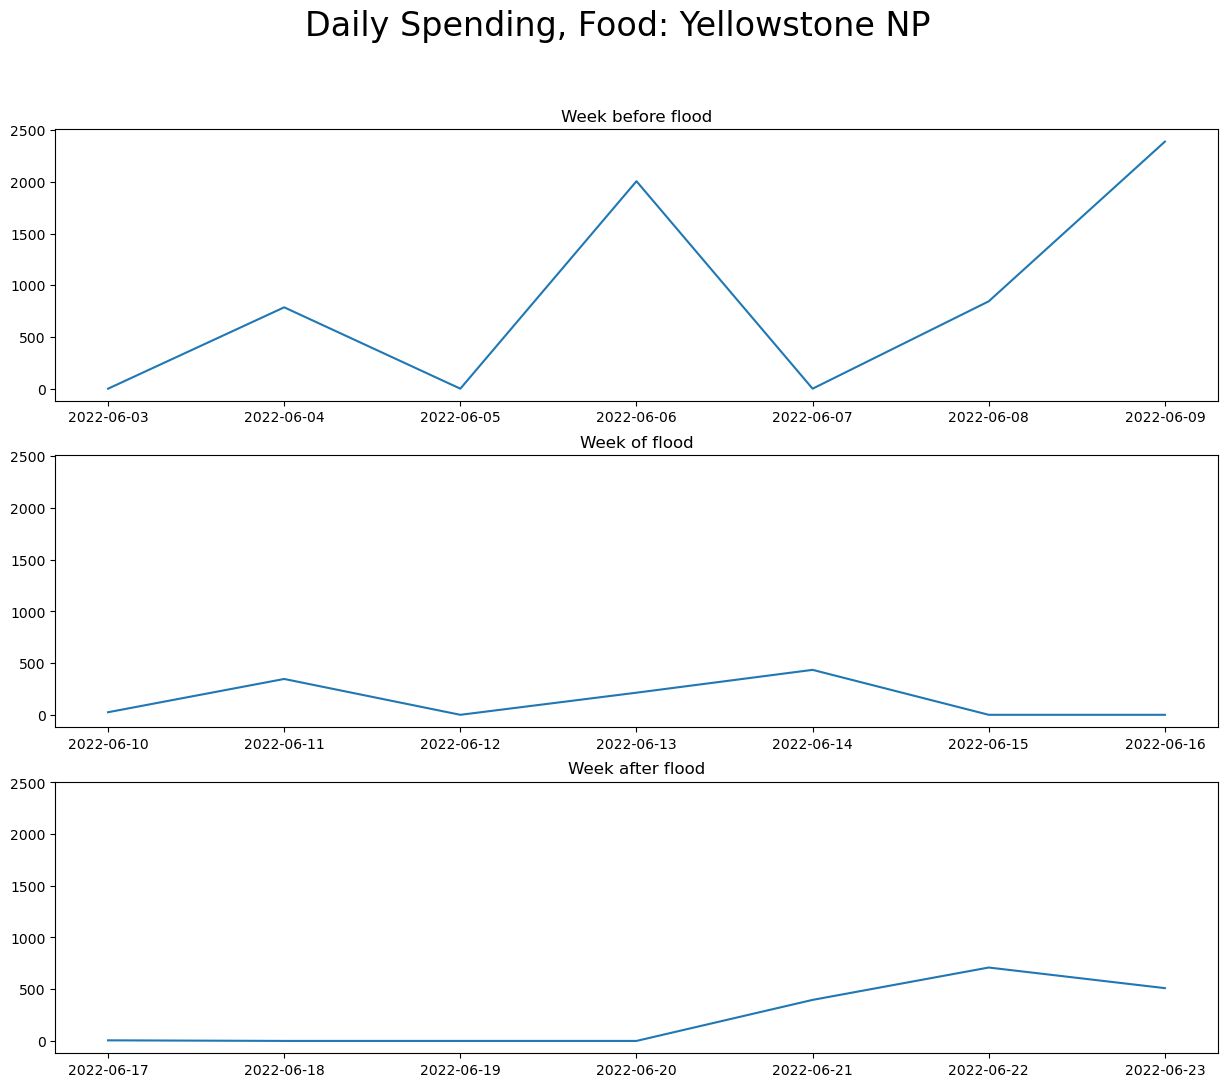

In [36]:
df_food_flood = time_filt(df_park_food, '2022-05-01', '2022-08-01')
df_flood_spending_food = spend_by_day(df_food_flood)

before_flood_food = df_flood_spending_food[33:40]
during_flood_food = df_flood_spending_food[40:47]
after_flood_food = df_flood_spending_food[47:54]
print(before_flood_food)
print(during_flood_food)
print(after_flood_food)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_food)
ax1.set_title('Week before flood');
ax2.plot(during_flood_food)
ax2.set_title('Week of flood');
ax3.plot(after_flood_food)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Food: Yellowstone NP', fontsize='24');

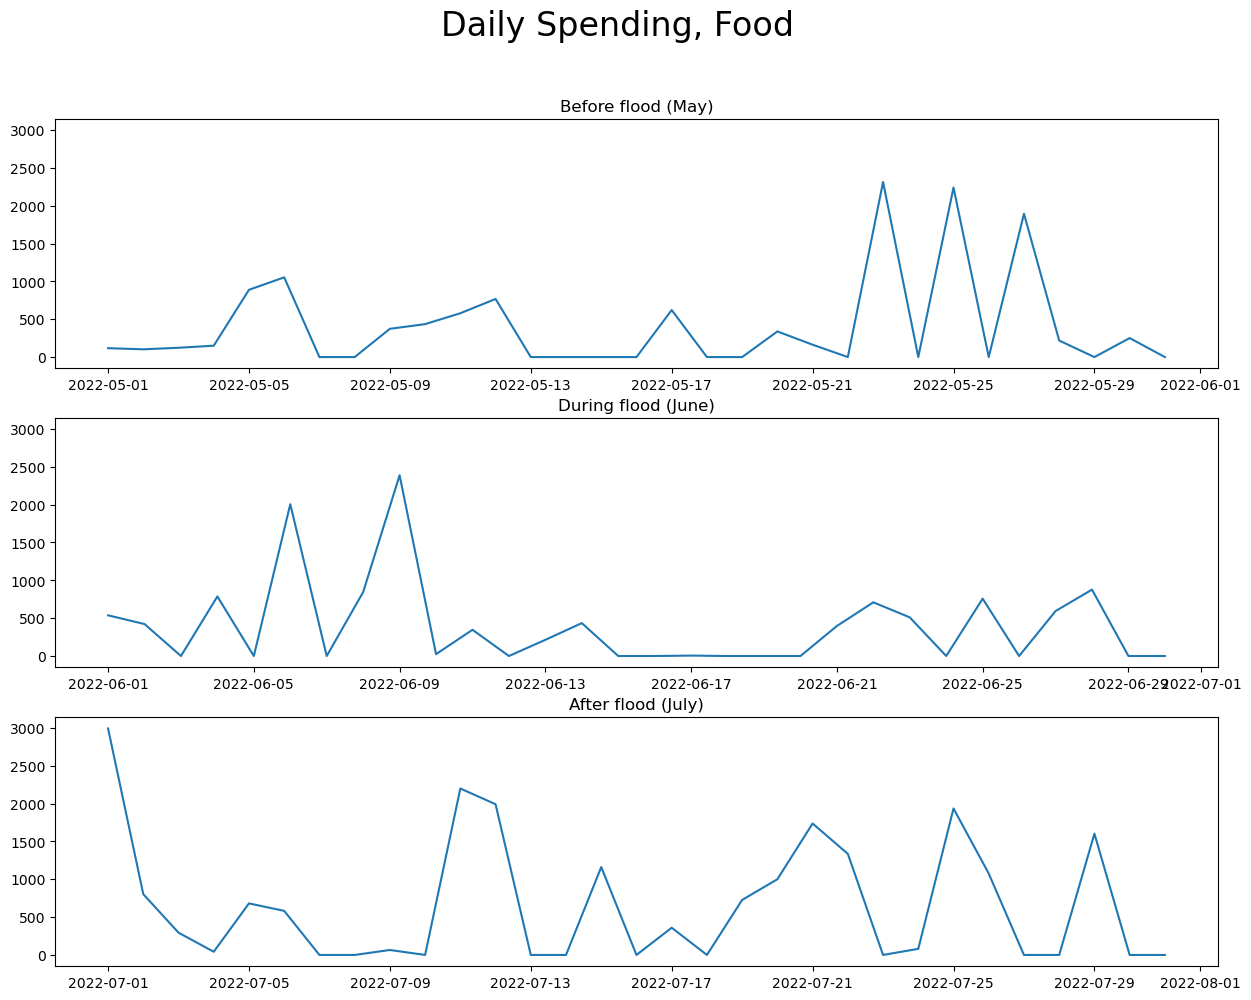

In [37]:
df_spend_before_food = spend_by_day(df_food_before)
df_spend_during_food = spend_by_day(df_food_during)
df_spend_after_food = spend_by_day(df_food_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_food)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_food)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_food)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Food', fontsize='24');

Before Flooding: 
Out of state:  273
In state:  2
Percentage out of state: 99.27272727272727 %


During Flooding: 
Out of state:  367
In state:  4
Percentage out of state: 98.92183288409704 %


After Flooding: 
Out of state:  382
In state:  12
Percentage out of state: 96.95431472081218 %




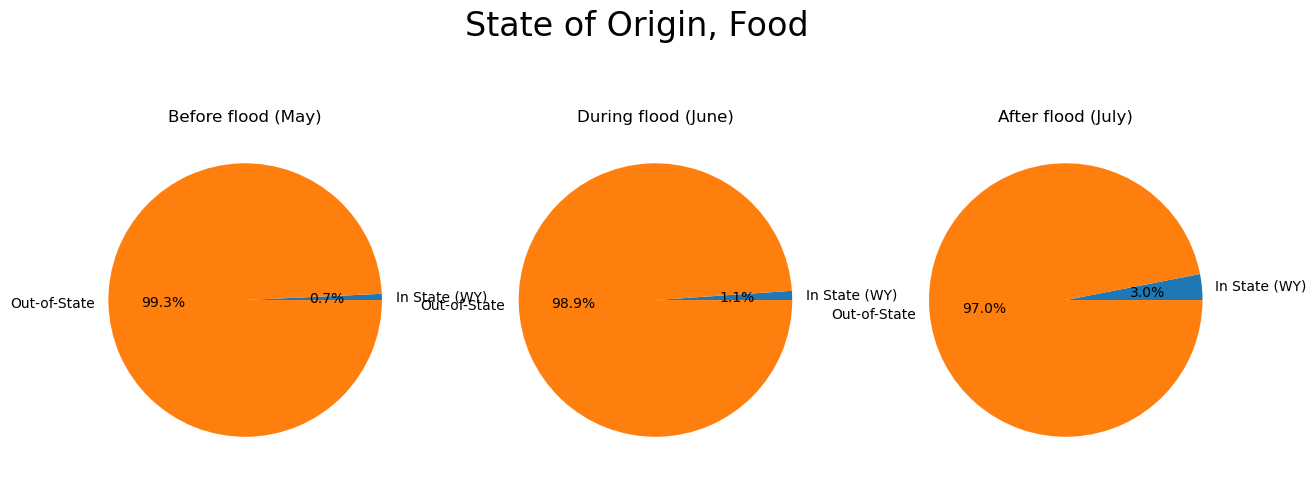

In [38]:
print('Before Flooding: ')
before = percent_instate(df_food_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_food_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_food_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Food', fontsize='24');

In [40]:
df_food_jan = time_filt(df_park_food, month[0], month[1])
df_food_feb = time_filt(df_park_food, month[1], month[2])
df_food_mar = time_filt(df_park_food, month[2], month[3])
df_food_apr = time_filt(df_park_food, month[3], month[4])
df_food_may = time_filt(df_park_food, month[4], month[5])
df_food_jun = time_filt(df_park_food, month[5], month[6])
df_food_jul = time_filt(df_park_food, month[6], month[7])
df_food_aug = time_filt(df_park_food, month[7], month[8])
df_food_sep = time_filt(df_park_food, month[8], month[9])
df_food_oct = time_filt(df_park_food, month[9], month[10])
df_food_nov = time_filt(df_park_food, month[10], month[11])
df_food_dec = time_filt(df_park_food, month[11], month[12])

food_dfs = [df_food_jan, df_food_feb, df_food_mar, df_food_apr, df_food_may, df_food_jun, 
             df_food_jul, df_food_aug, df_food_sep, df_food_oct, df_food_nov, df_food_dec]

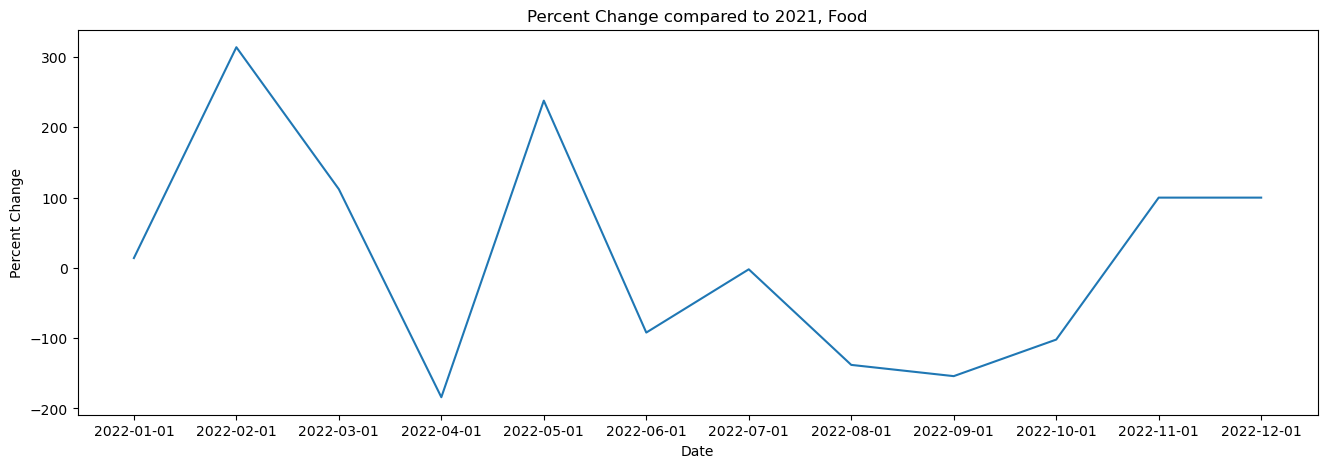

In [41]:
prev_year_pct=[]

for i in range(0, len(food_dfs)):
    prev_year_pct.append(percent_change_year(food_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Food');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

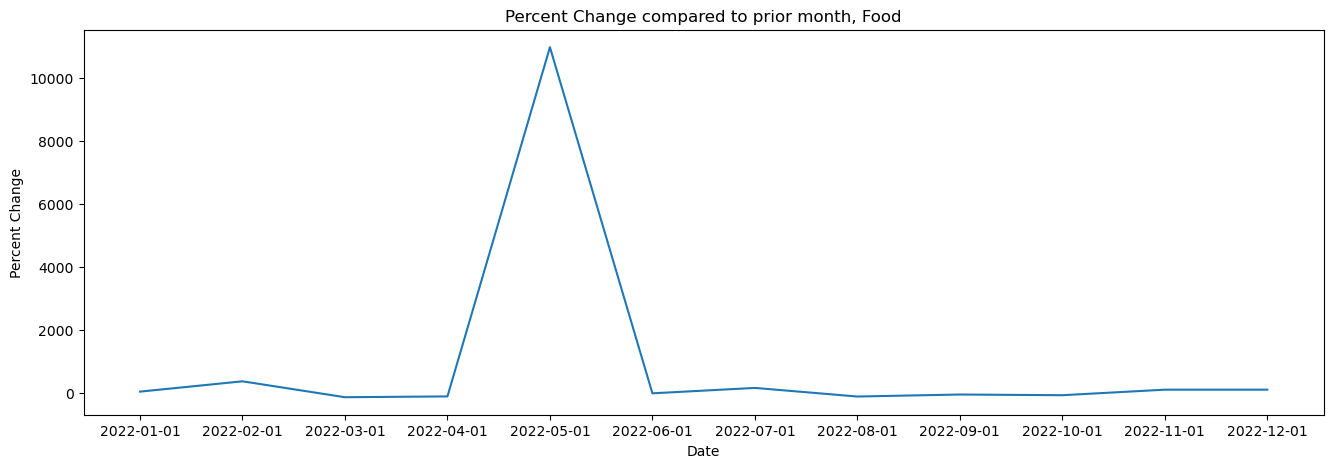

In [42]:
prev_month_pct=[]

for i in range(0, len(food_dfs)):
    prev_month_pct.append(percent_change_month(food_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Food');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Yellowstone National Park Retail

In [48]:
retail_naics = ['452', '445', '451', '448', '446', '711', '712', '713']
combined_mask = np.zeros(len(df_park_poi),dtype=bool)
for i in retail_naics:
    mask = [ str(ncode)[:3]==i for ncode in list(df_park_poi['NAICS_CODE']) ]
    combined_mask += mask
df_retail_poi = df_park_poi[combined_mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_park_retail = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_retail_poi['PLACEKEY'])]

df_retail_before = time_filt(df_park_retail, before_flood_start, before_flood_end)
print(df_retail_before.head(5), '\n')

df_retail_during = time_filt(df_park_retail, during_flood_start, during_flood_end)
print(df_retail_during.head(5), '\n')

df_retail_after = time_filt(df_park_retail, after_flood_start, after_flood_end)
print(df_retail_after.head(5), '\n')

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                   BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT RELATED_CROSS_SHOPPING_SAME_CATEGORY_BR

DATE
2022-06-03     850.0
2022-06-04     165.0
2022-06-05      35.0
2022-06-06    1278.0
2022-06-07     566.0
2022-06-08     306.0
2022-06-09     580.0
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     830.0
2022-06-11     115.0
2022-06-12      73.0
2022-06-13    1520.0
2022-06-14       0.0
2022-06-15       0.0
2022-06-16       0.0
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17      0.0
2022-06-18      0.0
2022-06-19      0.0
2022-06-20      0.0
2022-06-21    402.0
2022-06-22    187.0
2022-06-23    216.0
Name: SPEND_BY_DAY, dtype: float64


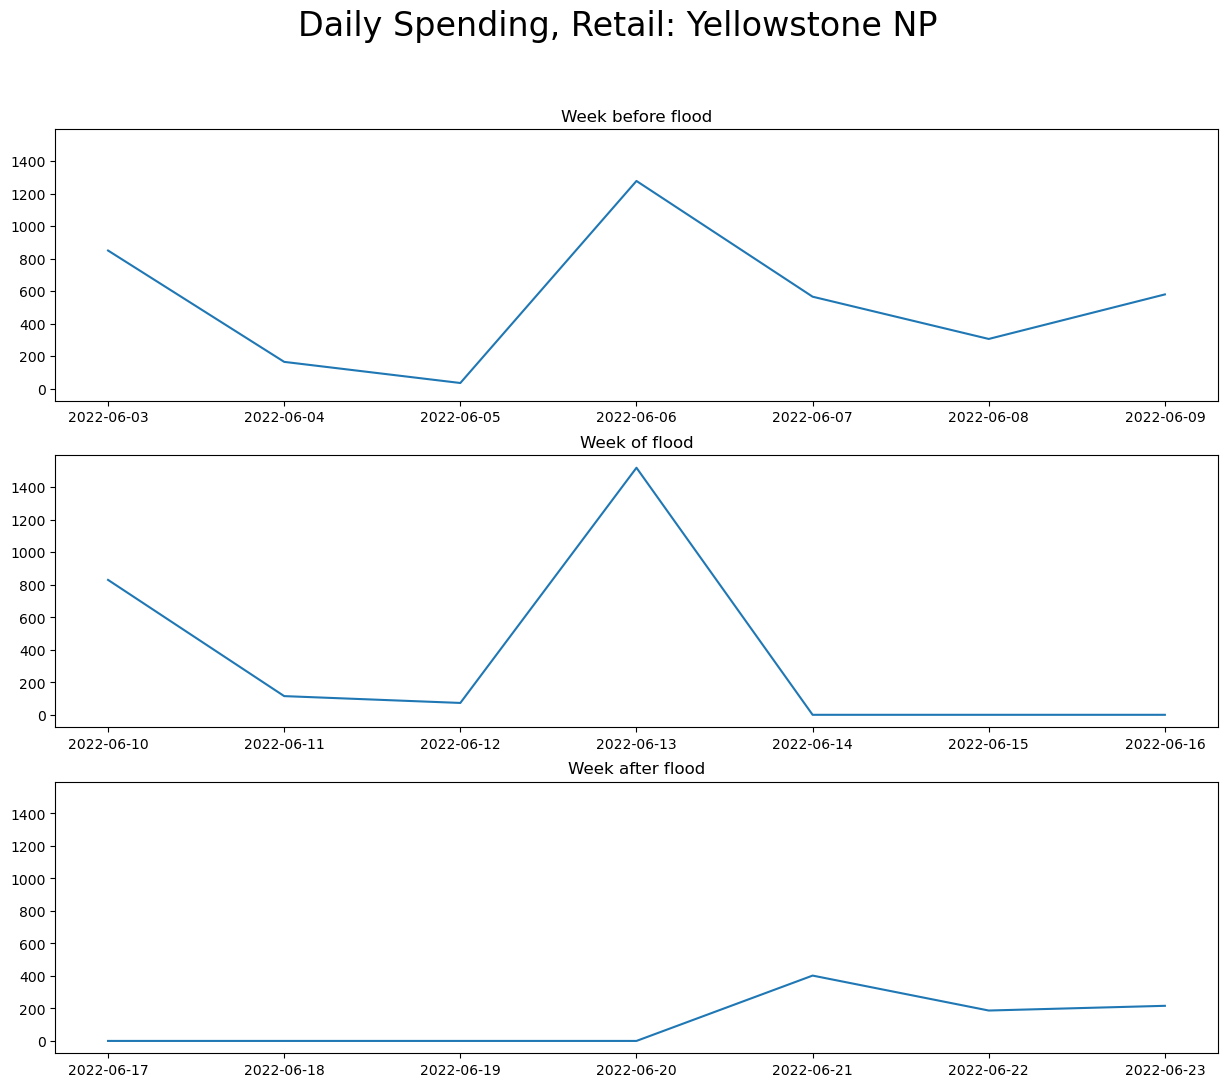

In [49]:
df_retail_flood = time_filt(df_park_retail, '2022-05-01', '2022-08-01')
df_flood_spending_retail = spend_by_day(df_retail_flood)

before_flood_retail = df_flood_spending_retail[33:40]
during_flood_retail = df_flood_spending_retail[40:47]
after_flood_retail = df_flood_spending_retail[47:54]
print(before_flood_retail)
print(during_flood_retail)
print(after_flood_retail)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_retail)
ax1.set_title('Week before flood');
ax2.plot(during_flood_retail)
ax2.set_title('Week of flood');
ax3.plot(after_flood_retail)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Retail: Yellowstone NP', fontsize='24');

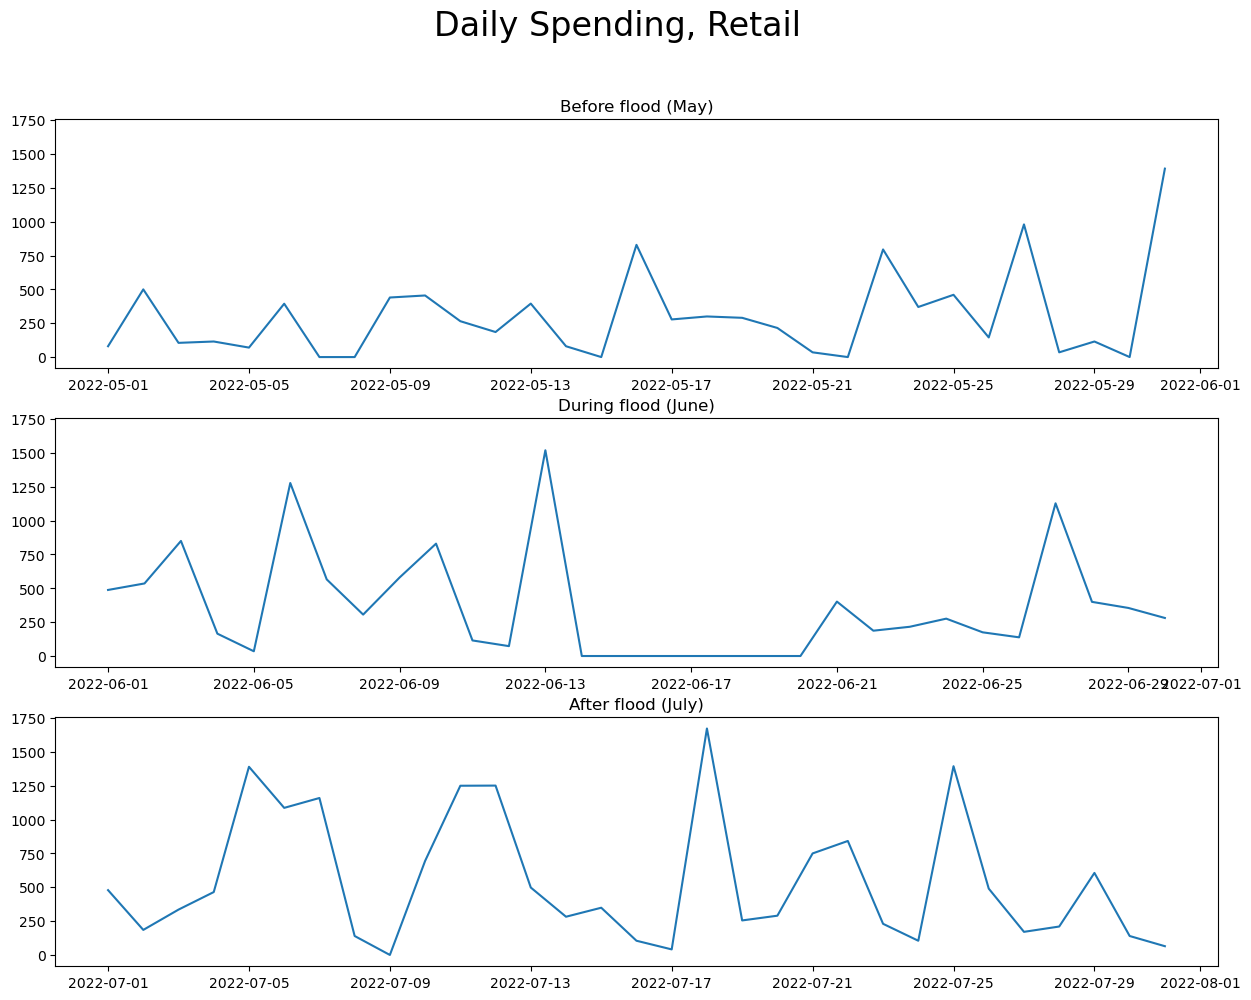

In [50]:
df_spend_before_retail = spend_by_day(df_retail_before)
df_spend_during_retail = spend_by_day(df_retail_during)
df_spend_after_retail = spend_by_day(df_retail_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_retail)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_retail)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_retail)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Retail', fontsize='24');

Before Flooding: 
Out of state:  334
In state:  2
Percentage out of state: 99.40476190476191 %


During Flooding: 
Out of state:  414
In state:  4
Percentage out of state: 99.04306220095694 %


After Flooding: 
Out of state:  299
In state:  2
Percentage out of state: 99.33554817275747 %




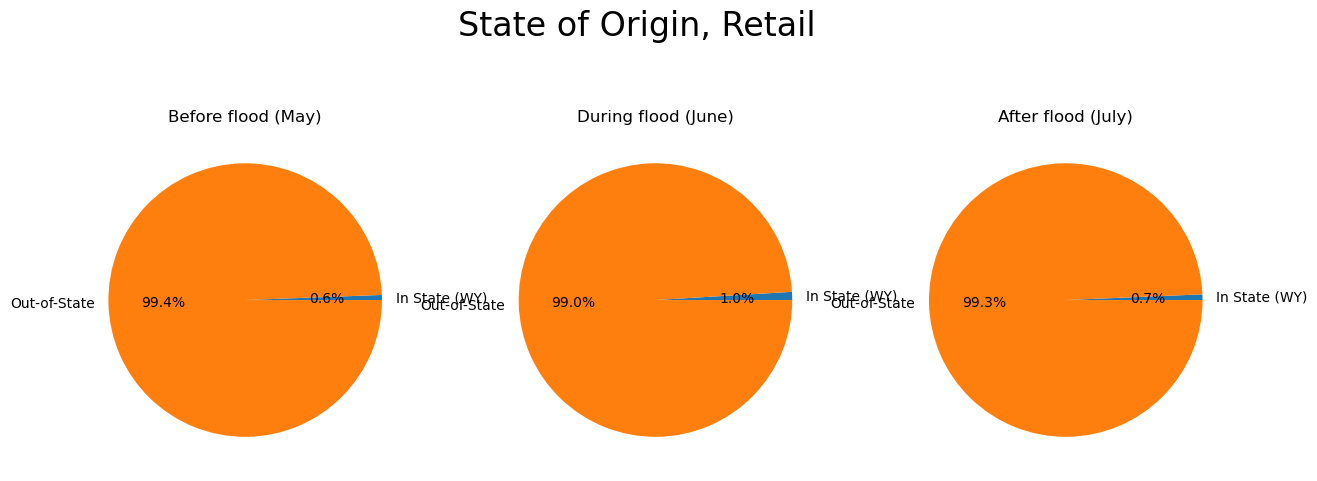

In [51]:
print('Before Flooding: ')
before = percent_instate(df_retail_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_retail_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_retail_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Retail', fontsize='24');

In [52]:
df_retail_jan = time_filt(df_park_retail, month[0], month[1])
df_retail_feb = time_filt(df_park_retail, month[1], month[2])
df_retail_mar = time_filt(df_park_retail, month[2], month[3])
df_retail_apr = time_filt(df_park_retail, month[3], month[4])
df_retail_may = time_filt(df_park_retail, month[4], month[5])
df_retail_jun = time_filt(df_park_retail, month[5], month[6])
df_retail_jul = time_filt(df_park_retail, month[6], month[7])
df_retail_aug = time_filt(df_park_retail, month[7], month[8])
df_retail_sep = time_filt(df_park_retail, month[8], month[9])
df_retail_oct = time_filt(df_park_retail, month[9], month[10])
df_retail_nov = time_filt(df_park_retail, month[10], month[11])
df_retail_dec = time_filt(df_park_retail, month[11], month[12])

retail_dfs = [df_retail_jan, df_retail_feb, df_retail_mar, df_retail_apr, df_retail_may, df_retail_jun, 
             df_retail_jul, df_retail_aug, df_retail_sep, df_retail_oct, df_retail_nov, df_retail_dec]

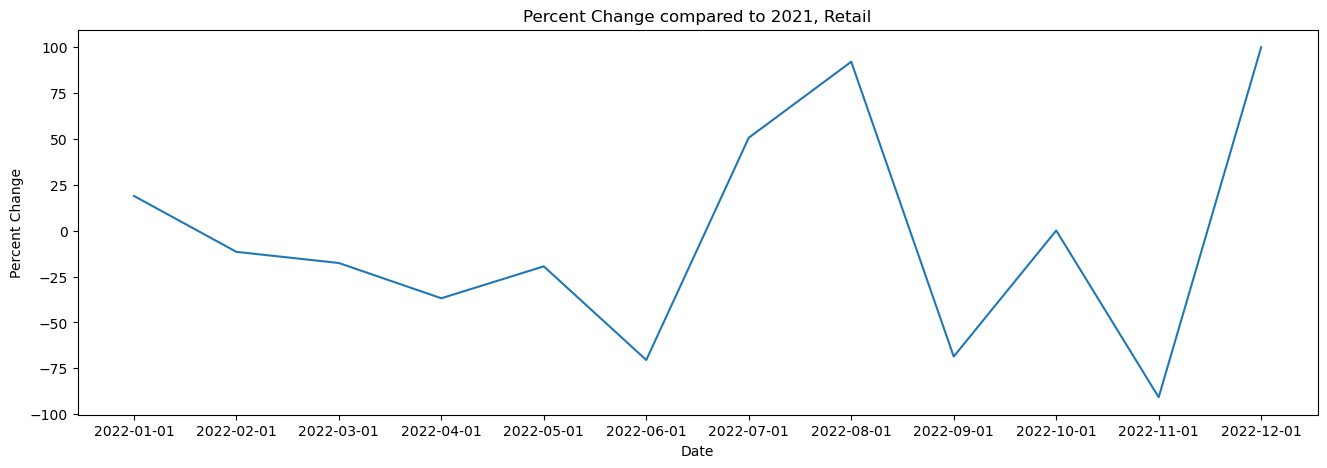

In [53]:
prev_year_pct=[]

for i in range(0, len(retail_dfs)):
    prev_year_pct.append(percent_change_year(retail_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Retail');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

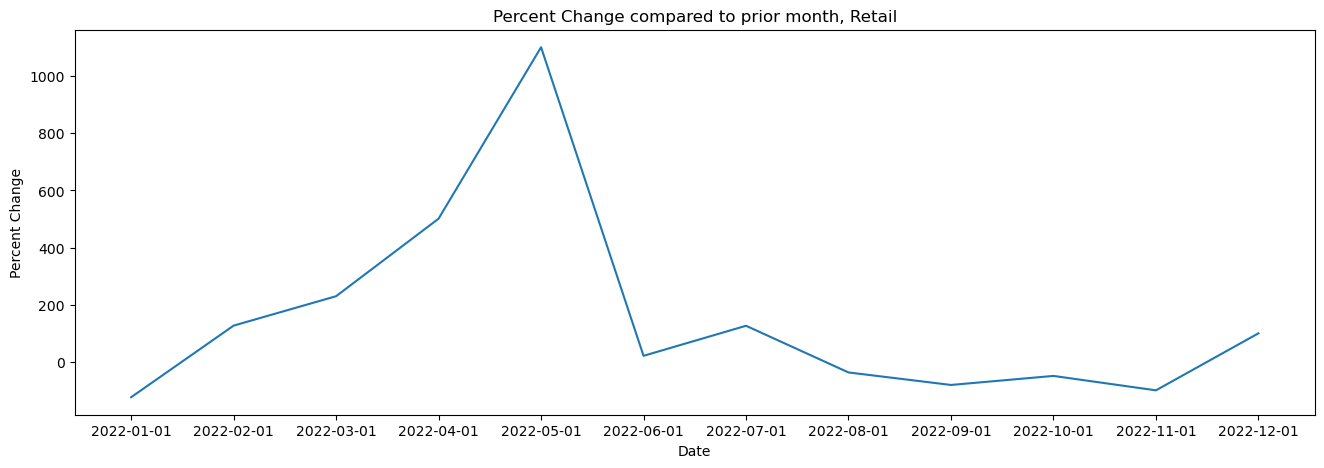

In [54]:
prev_month_pct=[]

for i in range(0, len(retail_dfs)):
    prev_month_pct.append(percent_change_month(retail_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Retail');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Cody Transportation

In [55]:
transit_naics = ['447', '485', '481']
combined_mask = np.zeros(len(df_park_poi),dtype=bool)
for i in transit_naics:
    mask = [ str(ncode)[:3]==i for ncode in list(df_park_poi['NAICS_CODE']) ]
    combined_mask += mask
df_transit_poi = df_park_poi[combined_mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_park_transit = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_transit_poi['PLACEKEY'])]

df_transit_before = time_filt(df_park_transit, before_flood_start, before_flood_end)
print(df_transit_before.head(5), '\n')

df_transit_during = time_filt(df_park_transit, during_flood_start, during_flood_end)
print(df_transit_during.head(5), '\n')

df_transit_after = time_filt(df_park_transit, after_flood_start, after_flood_end)
print(df_transit_after.head(5), '\n')

Empty DataFrame
Columns: [PLACEKEY, SAFEGRAPH_BRAND_IDS, BRANDS, SPEND_DATE_RANGE_START, SPEND_DATE_RANGE_END, RAW_TOTAL_SPEND, RAW_NUM_TRANSACTIONS, RAW_NUM_CUSTOMERS, MEDIAN_SPEND_PER_TRANSACTION, MEDIAN_SPEND_PER_CUSTOMER, SPEND_PER_TRANSACTION_PERCENTILES, SPEND_BY_DAY, SPEND_PER_TRANSACTION_BY_DAY, SPEND_BY_DAY_OF_WEEK, DAY_COUNTS, SPEND_PCT_CHANGE_VS_PREV_MONTH, SPEND_PCT_CHANGE_VS_PREV_YEAR, ONLINE_TRANSACTIONS, ONLINE_SPEND, TRANSACTION_INTERMEDIARY, SPEND_BY_TRANSACTION_INTERMEDIARY, BUCKETED_CUSTOMER_FREQUENCY, MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY, BUCKETED_CUSTOMER_INCOMES, MEAN_SPEND_PER_CUSTOMER_BY_INCOME, CUSTOMER_HOME_CITY, RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT, RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT, RELATED_CROSS_SHOPPING_SAME_CATEGORY_BRANDS_PCT, RELATED_CROSS_SHOPPING_LOCAL_BRANDS_PCT, RELATED_WIRELESS_CARRIER_PCT, RELATED_STREAMING_CABLE_PCT, RELATED_DELIVERY_SERVICE_PCT, RELATED_RIDESHARE_SERVICE_PCT, RELATED_BUYNOWPAYLATER_SERVICE_PCT, RELATED_PAYMENT_PL

Series([], Name: SPEND_BY_DAY, dtype: float64)
Series([], Name: SPEND_BY_DAY, dtype: float64)
Series([], Name: SPEND_BY_DAY, dtype: float64)


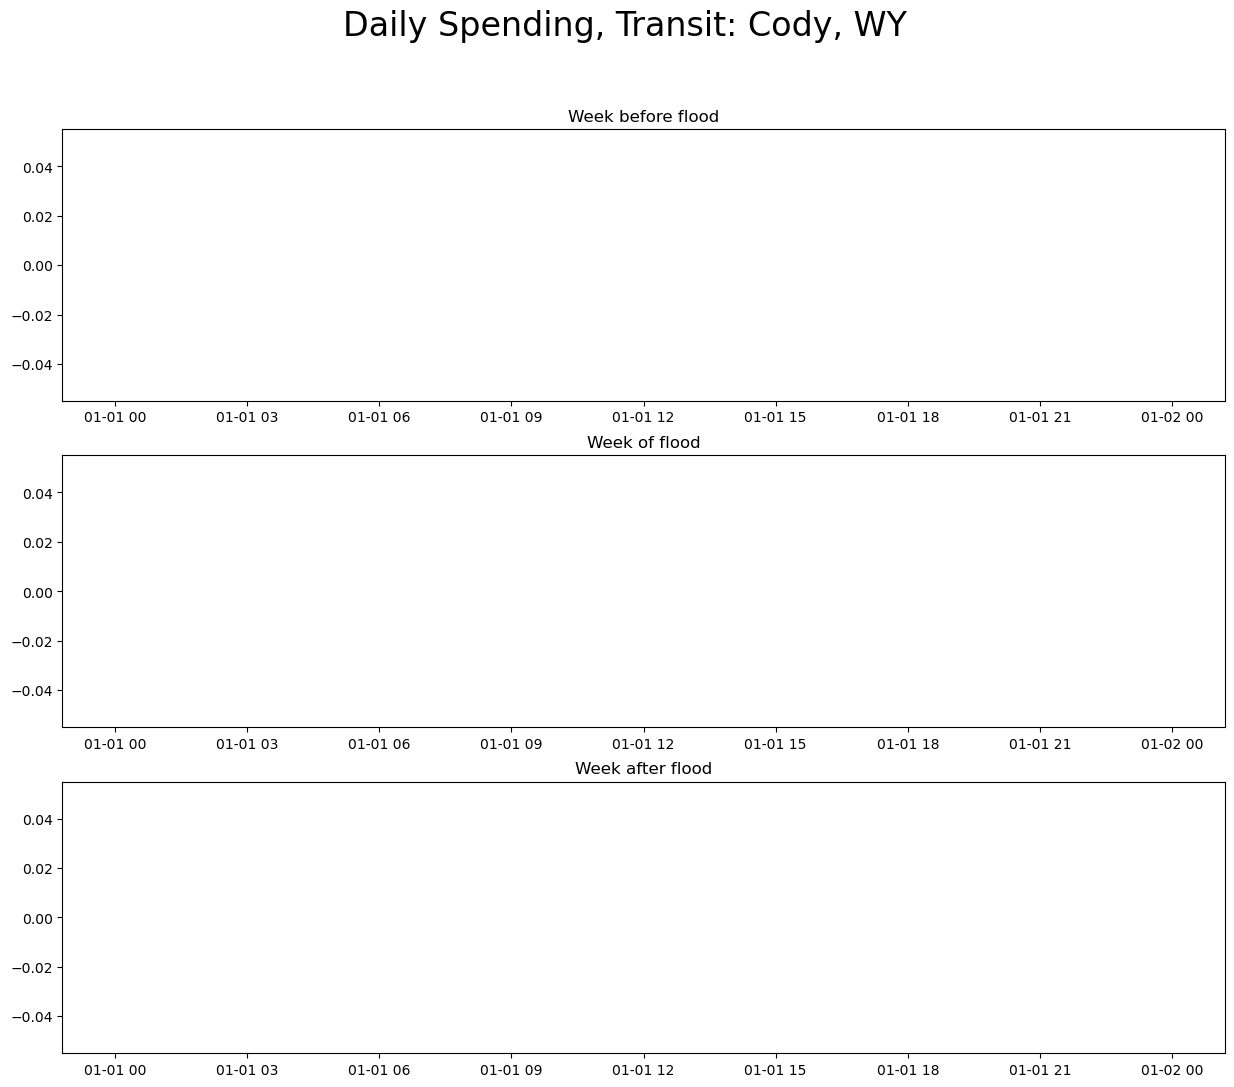

In [56]:
df_transit_flood = time_filt(df_park_transit, '2022-05-01', '2022-08-01')
df_flood_spending_transit = spend_by_day(df_transit_flood)

before_flood_transit = df_flood_spending_transit[33:40]
during_flood_transit = df_flood_spending_transit[40:47]
after_flood_transit = df_flood_spending_transit[47:54]
print(before_flood_transit)
print(during_flood_transit)
print(after_flood_transit)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_transit)
ax1.set_title('Week before flood');
ax2.plot(during_flood_transit)
ax2.set_title('Week of flood');
ax3.plot(after_flood_transit)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Transit: Cody, WY', fontsize='24');

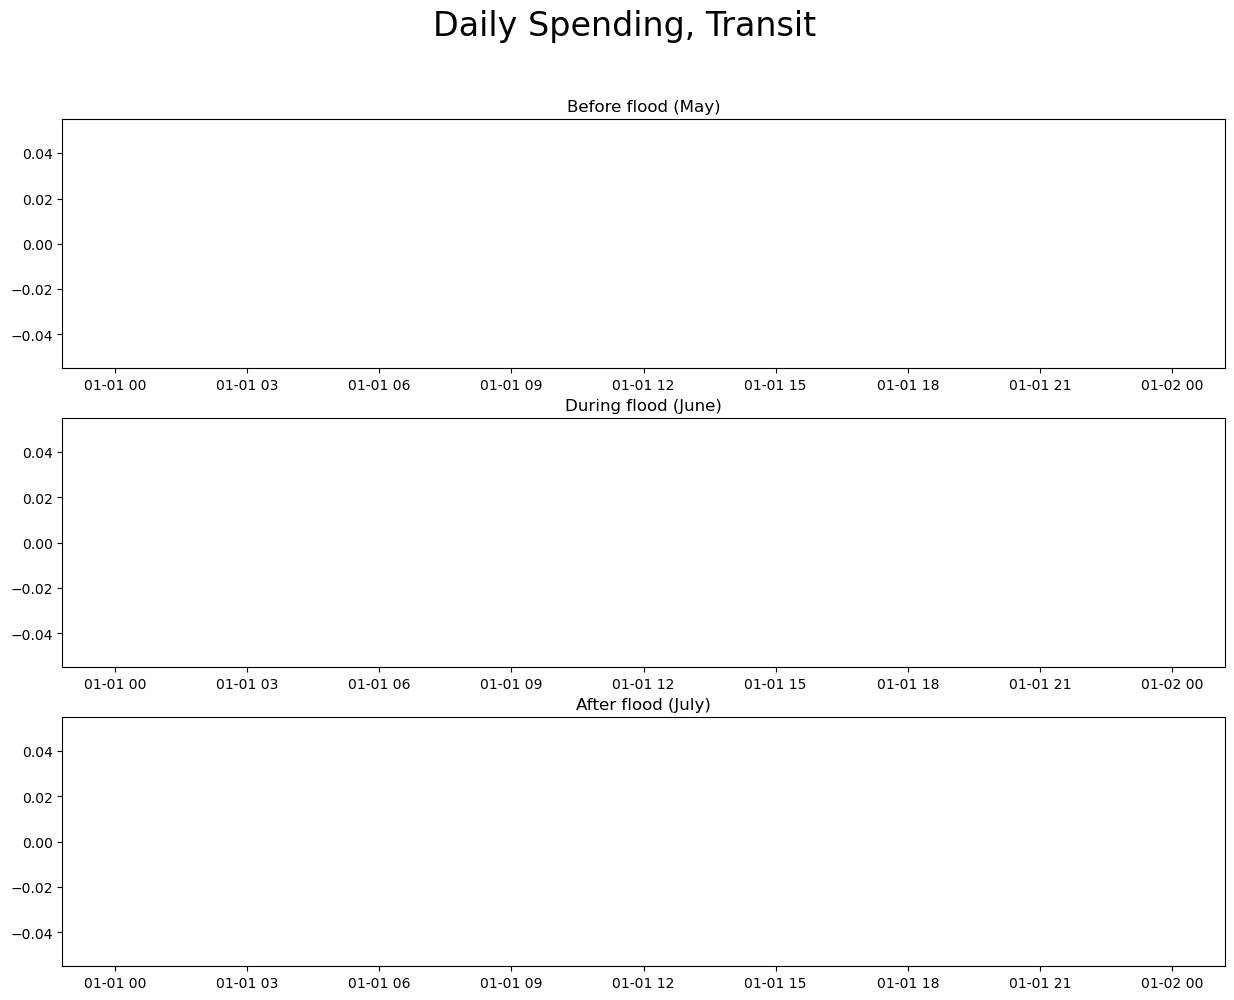

In [57]:
df_spend_before_transit = spend_by_day(df_transit_before)
df_spend_during_transit = spend_by_day(df_transit_during)
df_spend_after_transit = spend_by_day(df_transit_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_transit)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_transit)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_transit)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Transit', fontsize='24');

In [58]:
print('Before Flooding: ')
before = percent_instate(df_transit_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_transit_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_transit_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Transit', fontsize='24');

Before Flooding: 
Out of state:  0
In state:  0


ZeroDivisionError: division by zero

In [59]:
df_transit_jan = time_filt(df_park_transit, month[0], month[1])
df_transit_feb = time_filt(df_park_transit, month[1], month[2])
df_transit_mar = time_filt(df_park_transit, month[2], month[3])
df_transit_apr = time_filt(df_park_transit, month[3], month[4])
df_transit_may = time_filt(df_park_transit, month[4], month[5])
df_transit_jun = time_filt(df_park_transit, month[5], month[6])
df_transit_jul = time_filt(df_park_transit, month[6], month[7])
df_transit_aug = time_filt(df_park_transit, month[7], month[8])
df_transit_sep = time_filt(df_park_transit, month[8], month[9])
df_transit_oct = time_filt(df_park_transit, month[9], month[10])
df_transit_nov = time_filt(df_park_transit, month[10], month[11])
df_transit_dec = time_filt(df_park_transit, month[11], month[12])

transit_dfs = [df_transit_jan, df_transit_feb, df_transit_mar, df_transit_apr, df_transit_may, df_transit_jun, 
             df_transit_jul, df_transit_aug, df_transit_sep, df_transit_oct, df_transit_nov, df_transit_dec]

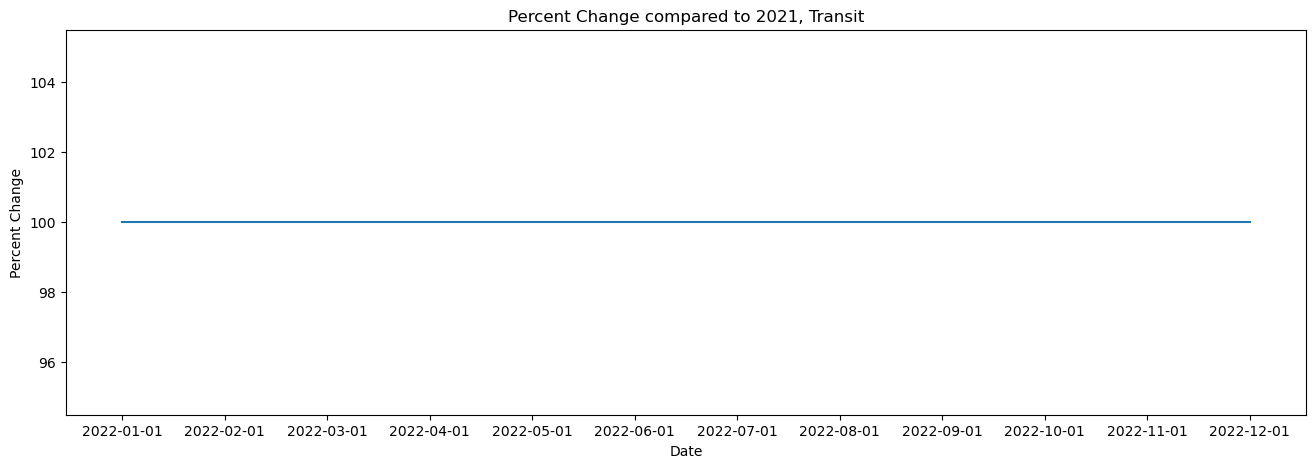

In [60]:
prev_year_pct=[]

for i in range(0, len(transit_dfs)):
    prev_year_pct.append(percent_change_year(transit_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Transit');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

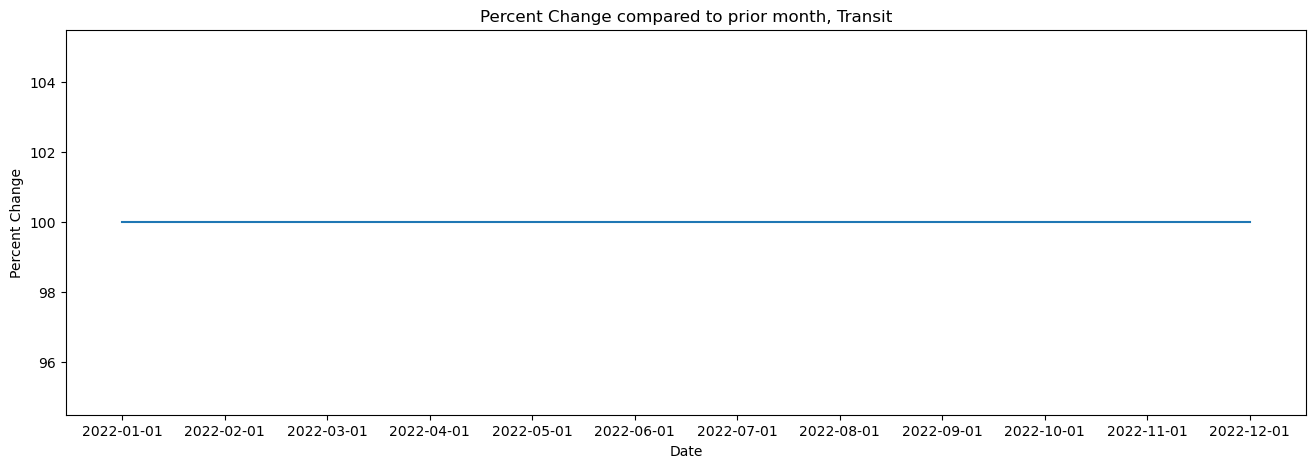

In [61]:
prev_month_pct=[]

for i in range(0, len(transit_dfs)):
    prev_month_pct.append(percent_change_month(transit_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Transit');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Aggregate 

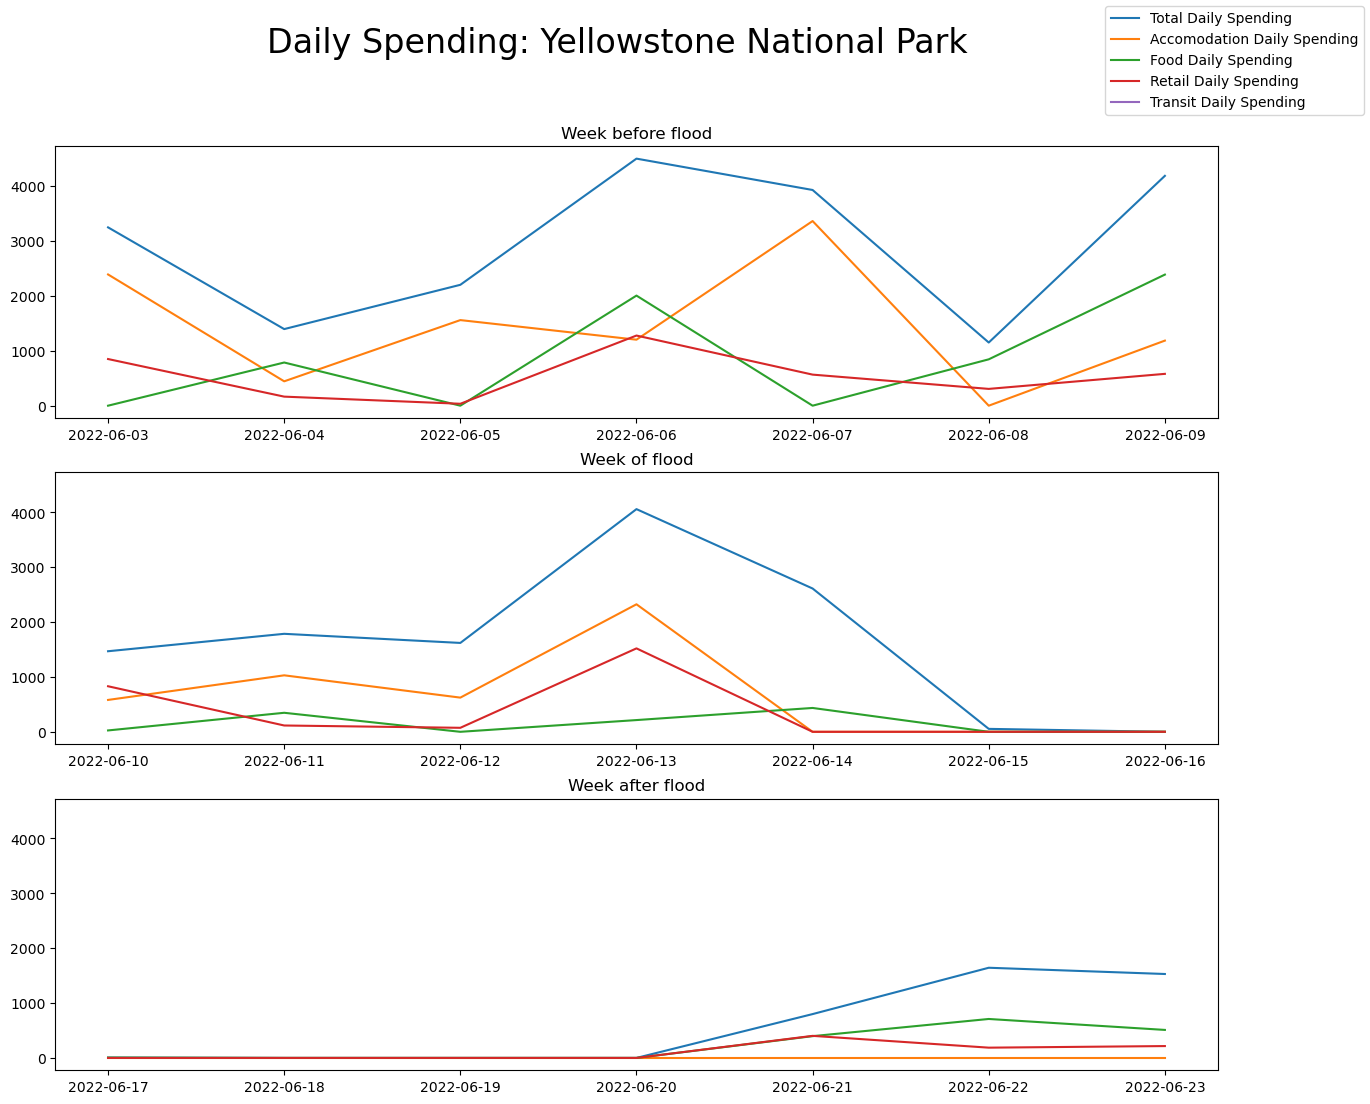

In [63]:
fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood, label='Total Daily Spending')
ax1.plot(before_flood_hotels, label='Accomodation Daily Spending');
ax1.plot(before_flood_food, label='Food Daily Spending')
ax1.plot(before_flood_retail, label='Retail Daily Spending')
ax1.plot(before_flood_transit, label='Transit Daily Spending')
ax1.set_title('Week before flood');
ax2.plot(during_flood)
ax2.plot(during_flood_hotels)
ax2.plot(during_flood_food)
ax2.plot(during_flood_retail)
ax2.plot(during_flood_transit)
ax2.set_title('Week of flood');
ax3.plot(after_flood)
ax3.plot(after_flood_hotels)
ax3.plot(after_flood_food)
ax3.plot(after_flood_retail)
ax3.plot(after_flood_transit)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending: Yellowstone National Park', fontsize='24');
fig.legend();